In [ ]:
import sys
sys.path.append('../..')
from lcs import SRC_ROOT

In [10]:
%matplotlib widget
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
jax.config.update("jax_enable_x64", True)
from lcs.configs import *
from tqdm import tqdm
import jax.numpy as jnp
from lcs.utils import run_cfg_pair
from lcs import PAGEHEIGHT, TEXTWIDTH
from lcs.plotting_utils import *
import matplotlib.pyplot as plt
from lcs.joint_learning import generate_teachers

In [12]:
common_overrides = dict(
    cfg_full_,
    t_tot=20.0,
    log_aux=False,
)

full_overrides = dict(
    T_tape=-1,
    dt=.03,  # few-shot learning
    batch_size=1,   # few-shot learning
    num_seeds=100,  # to get good statistics
    )

cfg_full = Config(**dict(cfg_full_, **full_overrides, ))

if cfg_full.teacher_scale == 'unit':
    sv_scale_full = 1.
elif cfg_full.teacher_scale == 'd_in':
    sv_scale_full = 1. / cfg_full.input_size**.5
elif cfg_full.teacher_scale == 'num_sv':
    sv_scale_full = 1. / (min(cfg_full.input_size, cfg_full.output_size) // cfg_full.num_contexts)**.5
else:
    raise ValueError(f"Unknown teacher scale: {cfg_full.teacher_scale}")

[WARNING] [2024-11-21 14:13:17,146] in lcs.configs: Using a dt > 1e-3 introduces finite-size effects!


In [13]:
r = cfg_full.initialization_scale

dth = 45
th = 45 * np.pi / 180
w1 = np.array([np.cos(th - dth), np.sin(th - dth)])*r
w2 = np.array([np.cos(th + dth), np.sin(th + dth)])*r
w11, w12 = w1
w21, w22 = w2

W_init = jnp.array([[w11, w12], [w21, w22]]).reshape(2, 2, 1)
c_init = jnp.array([0.5, 0.5])

In [14]:
W_teachers, (U, S, VT) = generate_teachers(cfg_full.input_size, cfg_full.output_size, cfg_full.num_contexts, mode=cfg_full.teacher_mode, return_svd=True, scale=cfg_full.teacher_scale, rotate=cfg_full.teacher_rotate)
print(U.shape, S.shape, VT.shape)  # (mia), (ma), (maj)
print(S)

# construct high-d students
S_init = jnp.full_like(S, r)

BYPASS_SILENT_ALIGNMENT = False  # can be used to directly initialize weights in the SV space
if BYPASS_SILENT_ALIGNMENT:
    # use the teacher SVs
    W_init = jnp.einsum("pia,pa,paj->pij", U, S_init, VT)
else:
    # just iid
    W_init = jax.random.normal(jax.random.PRNGKey(987777942), (cfg_full.num_contexts, cfg_full.output_size, cfg_full.input_size)) * (r / jnp.sqrt(cfg_full.input_size))

(2, 10, 10) (2, 10) (2, 10, 20)
[[0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068
  0.2236068 0.2236068 0.2236068]
 [0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068 0.2236068
  0.2236068 0.2236068 0.2236068]]


In [15]:
# the commented lines represent addtional assumptions about the full model that make it closer to the toy model

# both have unit scale singular values
# the high-d model will therefore have y^T y = d_out
# the low-d model will have y^T y = 2

gate_speedup = jnp.sum(jnp.full((min(cfg_full.input_size, cfg_full.output_size),), sv_scale_full)**2)
tape_toy, cfg_toy, tape_full, cfg_full = run_cfg_pair(
    cfg_toy_ | common_overrides | dict(
        c_tau=cfg_full.c_tau / gate_speedup,
        ),  
    cfg_full_ | common_overrides | full_overrides | dict(
        W_teachers=W_teachers,
        ),
    w1,
    w2,
    average=False,
    params_init_full=dict(c1=c_init, W1=W_init),  # whether to init students already SV-aligned, skipping the Silent Alignment phase

)

[INFO] [2024-11-21 14:13:17,318] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=1,
       output_size=2,
       num_seeds=1,
       num_contexts=2,
       num_paths=2,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.1,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='full',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 0.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=<function get_n_phasic_curriculum.<locals>.Y_tgt at 0x3723f0310>,
       use_X=False,
       metric='cosine,cols',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_scale='d_in',
       teacher_rotate=True,
       t_tot=20.0,
       T_tot=20000,
       num_b

(667, 2, 2, 1)
(20000, 2, 2, 1)


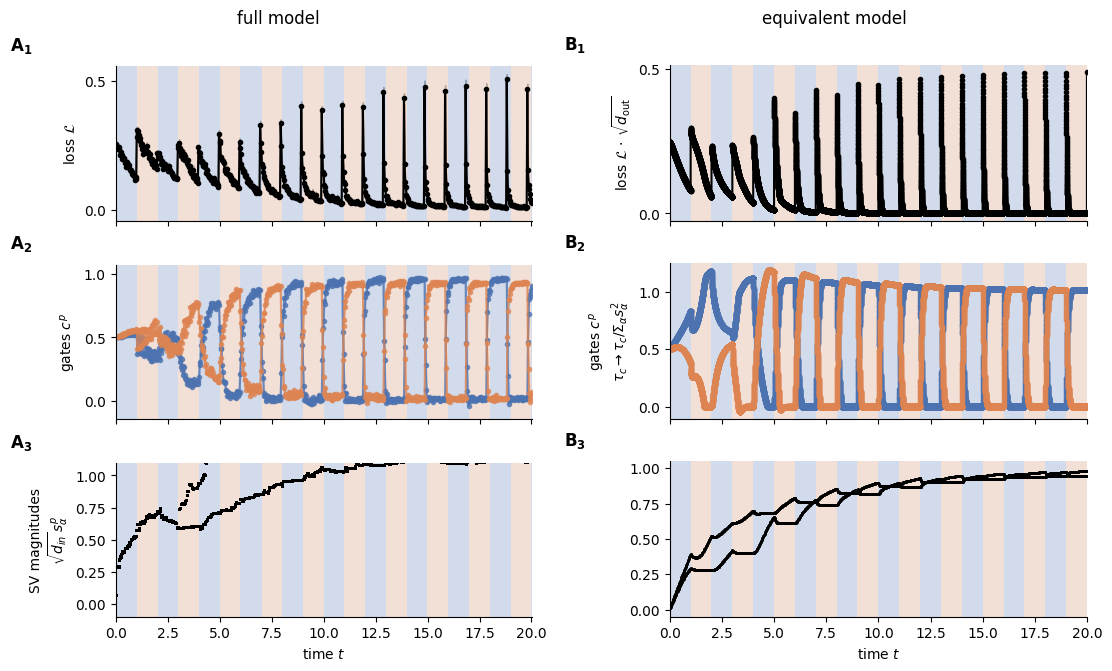

In [16]:
s = 2
fig = plt.figure(figsize=(s*TEXTWIDTH, s*PAGEHEIGHT*0.3), layout='constrained')
subfigs = fig.subfigures(1, 2)

figs = []
for i, (cfg, tape) in enumerate(zip([cfg_full, cfg_toy], [tape_full, tape_toy])):
    if i == 1:
        sv_scale = 1.
    else:
        sv_scale = sv_scale_full

    subfig = subfigs[i]
    subfig.suptitle(f"{'full model' if i == 0 else 'equivalent model'}")
    
    axd = subfig.subplot_mosaic('''
                                A
                                B
                                C
                                ''', sharex=True)
    
    largs = dict(marker='o', markersize=3)
    if i == 1:
        loss_scale = sv_scale_full**2 * (min(cfg_full.input_size, cfg_full.output_size) / (cfg_full.num_contexts if 'svd' in cfg_full.teacher_mode else 1.))
        loss_scale_div_str = r"\,\cdot\,\sqrt{d_\text{out}}" if True else r''
        tape = eqx.tree_at(lambda t: t.loss, tape, tape.loss * loss_scale)  # scale the loss to match the toy model
        
    else:
        loss_scale_div_str = ''

    plot_loss(axd['A'], tape, cfg, **largs, gauss_reduce=False,)
    axd['A'].dataLim.y0 = 0.0
    axd['A'].dataLim.y1 = 0.5
    axd['A'].autoscale_view()

    axd['A'].set_ylabel(r"loss $\mathcal{L}$" if i == 0 else rf"loss $\mathcal{{L}}{loss_scale_div_str}$")
    plot_c(axd['B'], tape, cfg, **dict(largs))
    if i == 1 and gate_speedup != 1:
        axd['B'].set_ylabel(r'gates $c^p$' + '\n' + r'$\tau_c \rightarrow \tau_c/\Sigma_\alpha s_\alpha^2$')

    W_teachers, W_students, t = tape.W_teachers[0], tape.W1[0], tape.t[0]

    K = compute_similarity(W_teachers[:, None], W_students[:, None, :], metric='svd,v,a', truncate=False)  # (T, M, P, A)
    S = compute_similarity(W_teachers[:, None], W_students[:, None, :], metric='svd,ab,sv', truncate=False)

    # compute silent alignment
    t_sub = np.linspace(0, tape.t.max(), 100)

    def silent_alignment_score(W_teachers, W_students, t_sub, which='U'):
        ti_sub = np.argmin(np.abs(tape.t - t_sub[:, None]), axis=1)

        vmap_SVD_p = jax.vmap(jnp.linalg.svd)
        vmap_SVD_ti = jax.vmap(jnp.linalg.svd, in_axes=(0), out_axes=0)
        U, S, VT = vmap_SVD_ti(W_students[ti_sub])

        # stack SVs p-wise
        T, P, A = U.shape[0], U.shape[1], U.shape[2]

        U_star, S_star, VT_star = vmap_SVD_p(W_teachers)

        # repeat along time
        U_star = jnp.repeat(U_star[None, ...], T, axis=0)
        S_star = jnp.repeat(S_star[None, ...], T, axis=0)
        VT_star = jnp.repeat(VT_star[None, ...], T, axis=0)
        
        if which == 'U':
            Z = jnp.swapaxes(U, -1, -2)  # (t, p, d, a) -> (t, p, a, d)
            Z_star = jnp.swapaxes(U_star, -1, -2)
        else:
            Z = VT
            Z_star = VT_star

        def contruct_matrix(Z, Z_star):
            # Z = (P, A, D)
            d = Z.shape[-1]
            M = jnp.full((A, A, 2*P, d), jnp.nan)
            for a in range(A):
                for b in range(A):
                    M = M.at[a, b].set(jnp.concatenate((Z[:, a, :], Z_star[:, b, :]), axis=0))
            return M
        
        construct_matrix = jax.vmap(contruct_matrix, in_axes=(0, 0), out_axes=0)  # vmap over time

        Z_Zstar_outer = construct_matrix(Z, Z_star)

        ranks = jnp.linalg.matrix_rank(Z_Zstar_outer, rtol=0.1)
        S_Z_Zstar = jnp.linalg.svd(Z_Zstar_outer, full_matrices=False, compute_uv=False)
        S_Z_Zstar = jnp.abs(S_Z_Zstar)
        S_Z_Zstar /= jnp.max(S_Z_Zstar, axis=(-1), keepdims=True)
        lmbd_Z_Zstar = jnp.abs(S_Z_Zstar)

        # participation ratio
        pr = jnp.sum(lmbd_Z_Zstar, axis=(-1))**2 / jnp.sum(lmbd_Z_Zstar**2, axis=(-1))

        def reduce(x):
            if i == 0:
                num_salient_sv_spaces = min(cfg_full.input_size, cfg_full.output_size) // cfg_full.num_contexts
            else:
                num_salient_sv_spaces = 1
            sorted_ranks = jnp.sort(x.reshape(*x.shape[:-2], -1),  # (a,b) -> (a*b)
                                    axis=-1)
            return jnp.mean(sorted_ranks[..., :num_salient_sv_spaces], axis=-1)

        rank = reduce(ranks)
        pr = reduce(pr)
        min_sv = jnp.min(S_Z_Zstar, axis=(-1))
        return rank, pr, min_sv, S_Z_Zstar
    
    rank, pr, min_sv, S_Z_Zstar = silent_alignment_score(W_teachers, W_students, t_sub, which='V')

    if K.ndim < 4:
        K = jnp.expand_dims(K, -1)
    print(K.shape)
    K = np.abs(K)

    diag = np.eye(K.shape[-1]).astype(bool)
    cutoff = 2
    max_t = 1000

    from matplotlib.colors import PowerNorm
    nrm = PowerNorm(gamma=1, vmin=0, vmax=1)
    colors = [
        (0, (1, 1, 1, 1)), # full white 
        (1, (0, 0, 0, 1)) # full black
              ]
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

    skip = max(tape.t.shape[-1] // max_t, 1)
    for m in range(K.shape[1]):
        for p in range(K.shape[2]):
            for a in range(K.shape[3]):
                k = K[:, m, p, a]
                s_max = S.max()
                k_max = K.max()
                for b in range(K.shape[-1])[:cutoff]:
                    pass
    
    skip = max(tape.t.shape[-1] // max_t, 1)
    for m in range(S.shape[-4]):
        for p in range(S.shape[-2]):
            for a in range(S.shape[-3])[:cutoff]:
                s = S[:, m, a, p, :].reshape(K.shape[0], -1)
                s_max = S.max()
                for b in range(K.shape[-1])[:cutoff]:
                    pass
                    axd['C'].scatter(t[::skip], s[::skip, b] / sv_scale, s=1, c='k')

    for k, ax in axd.items():
        indicate_contexts(ax, tape, cfg,)

    figs.append(subfig)

    setup_axes_labels(axd, labels=[('A' if i == 0 else 'B') + f'_{j}' for j in range(1, 10)])

    if i == 0:
        axd['C'].set_ylabel(r'SV magnitudes' + '\n' r'$\sqrt{d_{in}}\,s_\alpha^p$')


    list(axd.values())[-1].set_xlabel('time $t$')

for letter, axA, axB in zip('ABCDEFG', figs[0].axes, figs[1].axes):
    axA.autoscale(enable=True)
    axB.autoscale(enable=True)
    axA.relim()
    axB.relim()
    

    if letter == 'C' or letter == 'D':
        axA.dataLim.y0 = 0.0
        axA.dataLim.y1 = 1.0
        axB.dataLim.y0 = 0.0
        axB.dataLim.y1 = 1.0

    if letter == 'E':
        axA.dataLim.y0 = 0.0
        axA.dataLim.y1 = 4.0
        axB.dataLim.y0 = 0.0
        axB.dataLim.y1 = 4.0

    axA.margins(y=.1)
    axA.autoscale_view()
plt.show()
fig

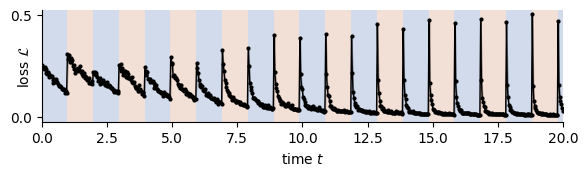

In [17]:
s = 1.5
fig, ax = plt.subplots(figsize=(s*TEXTWIDTH*.7, s*PAGEHEIGHT*0.1), layout='constrained')
ax.cla()
plot_loss(ax, tape_full, cfg_full, **dict(largs, markersize=2, linewidth=1), )
ax.set_xlabel('time $t$')
ax.dataLim.y0 = 0.0
ax.dataLim.y1 = 0.5
ax.autoscale_view()
indicate_contexts(ax, tape_full, cfg_full, use_tape=True)
ax.set_xlim(0, 20)
xylabel_to_ticks(ax, which='y')
fig